# Feature Engineering for Stroke Prediction

 **Preparing the processed dataset for modeling** 

### Handling missing data

* The BMI column had 201 NaN values. 
* Since the NaN make up roughly 4% of the value count, the best way to impute is by using median.

### Handling imbalance in the target column

* In the EDA analysis, the split represented c95% of 0s vs c5% of 1s. 
* I shall be considering variuos options to balance out a 50/50 split before proceeding to model training.

### Encoding the categorical features

* One hot encoding is my choice for encoding

In [54]:
#Loading the processed dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('../Data/processed_stroke_data.parquet')
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [55]:
#Checking if Mean or Media are better for imputing missing values in 'bmi' column
median_impute = df['bmi'].fillna(df['bmi'].median(), inplace=False)
print("Missing values after median imputation:") 
print(df['bmi'].isnull().sum())

mean_impute = df['bmi'] = df['bmi'].fillna(df['bmi'].mean(), inplace=False)
print("Missing values after mean imputation:")
print(df['bmi'].isnull().sum())


Missing values after median imputation:
201
Missing values after mean imputation:
0


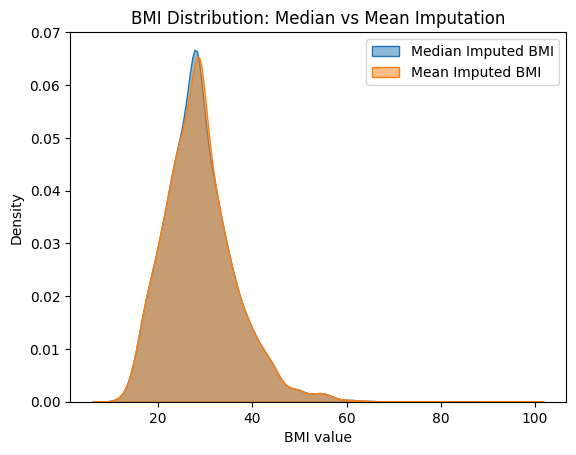

In [56]:
#Checking the distribution of BMI after imputation

df_compare = pd.DataFrame({
    'Median Imputed BMI': median_impute,
    'Mean Imputed BMI': mean_impute
})  
sns.kdeplot(df_compare['Median Imputed BMI'], label='Median Imputed BMI', fill=True, alpha=0.5)
sns.kdeplot(df_compare['Mean Imputed BMI'], label='Mean Imputed BMI', fill=True, alpha=0.5)
plt.title('BMI Distribution: Median vs Mean Imputation')
plt.xlabel('BMI value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [57]:
#checking skewness and kurtosis of bmi column
print(df['bmi'].skew())
print(df['bmi'].kurt())
print(df['bmi'].describe())


1.0767160713842094
3.6230613267307876
count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64


In [58]:
#Selecting median imputation as it preserves the distribution better in presence of skewness
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
#Final check for missing values
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [59]:
# Handling 'Other' category in 'gender' column by replacing it with the most frequent category 'Male

df['gender'] = df['gender'].replace({'Other':'Male'})
df['gender'].value_counts()

df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [60]:
#one hot encoding categorical variables
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = one_hot_encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(categorical_cols))
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)



In [66]:
#Removing the imbalance in target variable using SMOTE
from imblearn.over_sampling import SMOTE

X = df.drop(columns = ['stroke']) # features
y = df['stroke'] # target variable

# resampling using SMOTE
smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#X_resampled back into a dataframe with proper column names
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

#reset index of y_resampled
y_resampled = y_resampled.reset_index(drop=True)

#Combining X_resampled and y_resampled into a single dataframe
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

#Check the imbalance after resampling
y_resampled.value_counts(normalize=True) * 100

stroke
1    50.0
0    50.0
Name: proportion, dtype: float64

In [72]:
#pie chart to show the balance after resampling
import plotly.express as px

target_counts = df_resampled['stroke'].value_counts().reset_index()
target_counts.columns = ['stroke', 'count']

fig = px.pie(target_counts, names='stroke', values='count', 
             color='stroke', color_discrete_map={0: 'lightblue', 1: 'orange'},
             title='Class Distribution of Stroke after SMOTE')
fig.update_traces(textinfo='percent+label', pull=[0, 0.1])
fig.show()



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [62]:
#save feature engineered dataframe to parquet
df_resampled.to_parquet('../Data/feature_engineered_stroke_data.parquet', index=False)